In [1]:
"""Tutorial on how to create a convolutional autoencoder w/ Tensorflow.

Parag K. Mital, Jan 2016
"""

'Tutorial on how to create a convolutional autoencoder w/ Tensorflow.\n\nParag K. Mital, Jan 2016\n'

In [2]:
import tensorflow as tf
import numpy as np
import math
from activations import lrelu
from utils import corrupt
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
# %%
def autoencoder(input_shape=[None, 784],
                n_filters=[1, 10, 10, 10],
                filter_sizes=[3, 3, 3, 3],
                corruption=False):
    """Build a deep denoising autoencoder w/ tied weights.

    Parameters
    ----------
    input_shape : list, optional
        Description
    n_filters : list, optional
        Description
    filter_sizes : list, optional
        Description

    Returns
    -------
    x : Tensor
        Input placeholder to the network
    z : Tensor
        Inner-most latent representation
    y : Tensor
        Output reconstruction of the input
    cost : Tensor
        Overall cost to use for training

    Raises
    ------
    ValueError
        Description
    """
    # %%
    # input to the network
    x = tf.placeholder(
        tf.float32, input_shape, name='x')

    # %%
    # Optionally apply denoising autoencoder
    if corruption:
        x_noise = corrupt(x)
    else:
        x_noise = x

    # %%
    # ensure 2-d is converted to square tensor.
    if len(x.get_shape()) == 2:
        x_dim = np.sqrt(x_noise.get_shape().as_list()[1])
        if x_dim != int(x_dim):
            raise ValueError('Unsupported input dimensions')
        x_dim = int(x_dim)
        x_tensor = tf.reshape(
            x_noise, [-1, x_dim, x_dim, n_filters[0]])
    elif len(x_noise.get_shape()) == 4:
        x_tensor = x_noise
    else:
        raise ValueError('Unsupported input dimensions')
    current_input = x_tensor

    # %%
    # Build the encoder
    encoder = []
    shapes = []
    for layer_i, n_output in enumerate(n_filters[1:]):
        n_input = current_input.get_shape().as_list()[3]
        shapes.append(current_input.get_shape().as_list())
        W = tf.Variable(
            tf.random_uniform([
                filter_sizes[layer_i],
                filter_sizes[layer_i],
                n_input, n_output],
                -1.0 / math.sqrt(n_input),
                1.0 / math.sqrt(n_input)))
        b = tf.Variable(tf.zeros([n_output]))
        encoder.append(W)
        output = lrelu(
            tf.add(tf.nn.conv2d(
                current_input, W, strides=[1, 2, 2, 1], padding='SAME'), b))
        current_input = output

    # %%
    # store the latent representation
    z = current_input
    encoder.reverse()
    shapes.reverse()

    # %%
    # Build the decoder using the same weights
    for layer_i, shape in enumerate(shapes):
        W = encoder[layer_i]
        b = tf.Variable(tf.zeros([W.get_shape().as_list()[2]]))
        output = lrelu(tf.add(
            tf.nn.conv2d_transpose(
                current_input, W,
                tf.pack([tf.shape(x)[0], shape[1], shape[2], shape[3]]),
                strides=[1, 2, 2, 1], padding='SAME'), b))
        current_input = output

    # %%
    # now have the reconstruction through the network
    y = current_input
    # cost function measures pixel-wise difference
    cost = tf.reduce_sum(tf.square(y - x_tensor))

    # %%
    return {'x': x, 'z': z, 'y': y, 'cost': cost}

In [4]:
# %%
def test_mnist():
    """Test the convolutional autoencder using MNIST."""
    # %%
    import tensorflow as tf
    import tensorflow.examples.tutorials.mnist.input_data as input_data
    import matplotlib.pyplot as plt

    # %%
    # load MNIST as before
    mnist = input_data.read_data_sets('MNIST_data', one_hot=True)
    mean_img = np.mean(mnist.train.images, axis=0)
    ae = autoencoder()

    # %%
    learning_rate = 0.01
    optimizer = tf.train.AdamOptimizer(learning_rate).minimize(ae['cost'])

    # %%
    # We create a session to use the graph
    sess = tf.Session()
    sess.run(tf.initialize_all_variables())

    # %%
    # Fit all training data
    batch_size = 100
    n_epochs = 10
    for epoch_i in range(n_epochs):
        for batch_i in range(mnist.train.num_examples // batch_size):
            batch_xs, _ = mnist.train.next_batch(batch_size)
            train = np.array([img - mean_img for img in batch_xs])
            sess.run(optimizer, feed_dict={ae['x']: train})
        print(epoch_i, sess.run(ae['cost'], feed_dict={ae['x']: train}))

    # %%
    # Plot example reconstructions
    n_examples = 10
    test_xs, _ = mnist.test.next_batch(n_examples)
    test_xs_norm = np.array([img - mean_img for img in test_xs])
    recon = sess.run(ae['y'], feed_dict={ae['x']: test_xs_norm})
    print(recon.shape)
    fig, axs = plt.subplots(2, n_examples, figsize=(10, 2))
    for example_i in range(n_examples):
        axs[0][example_i].imshow(
            np.reshape(test_xs[example_i, :], (28, 28)))
        axs[1][example_i].imshow(
            np.reshape(
                np.reshape(recon[example_i, ...], (784,)) + mean_img,
                (28, 28)))

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz
0 770.611
1 675.235
2 646.396
3 657.611
4 606.486
5 583.355
6 631.006
7 628.034
8 586.437
9 611.301
(10, 28, 28, 1)


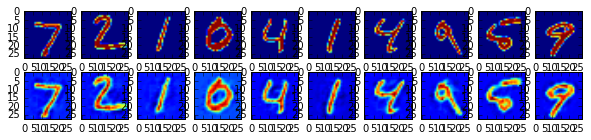

In [5]:
# %%
test_mnist()